# Preparations

In [1]:
import sys
import math
import copy
import itertools
import numpy as np
import collections

import scipy.stats
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.mlab import griddata

from sklearn.preprocessing import StandardScaler

sys.path.append('..')
from higgs_inference.various.utils import interpolate, format_number, asymptotic_p_value
from higgs_inference import settings


# Settings

In [2]:
# Interpolation in final plot.
interpolation_method = 'gp' #'linear' or 'gp'

# Which benchmark point to use
use_not_trained_benchmark = True

# Which algorithm to use for the PbP vs parameterized vs morphing-aware plot
use_regression_as_pbp_param_aware_example = False

# Neyman construction settings
neyman_plots = True
remove_duplicates_for_nc = False

# Asymptotics settings
use_median_rather_than_asimov = False


In [15]:
#colors     = ['black', '0.65', 'darkgreen',  'mediumblue',    'c', '#CC002E', 'orange', 'orange', 'darkgreen', 'mediumblue']
colors     = ['0.65', 'orange', 'darkgreen',  'mediumblue',  'c', '#CC002E', '#be96ff', 'orange', 'darkgreen', 'mediumblue']
linestyles = [  '-',     ':',   '--',       '-.',      ':',         '--',          '-.',        '-',         '--',  ':']
linewidths = [1.5 if ls == ':' else 1.5 for ls in linestyles]

scatter_alpha = 1.

def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb

#for color in colors:
#    print(color, matplotlib.colors.to_rgb(color))

In [4]:
thetas = np.load('../data/thetas/thetas_parameterized.npy')

n_thetas = len(thetas)
theta1 = 708
theta_observed = 0
thetas_train = list(range(17,1017))
thetas_test = list(range(17))

if use_not_trained_benchmark:
    theta_benchmark = 9
    benchmark_name = 'nottrained'
else:
    theta_benchmark = 422
    benchmark_name = 'trained'
    
pbp_training_thetas = [0, 13, 14, 15, 16, 9, 422, 956, 666, 802, 675, 839, 699, 820, 203, 291, 634, 371, 973, 742, 901, 181, 82, 937, 510, 919, 745, 588, 804, 963, 396, 62, 401, 925, 874, 770, 108, 179, 669, 758, 113, 587, 600, 975, 496, 66, 467, 412, 701, 986, 598, 810, 97, 18, 723, 159, 320, 301, 352, 159, 89, 421, 574, 923, 849, 299, 119, 167, 939, 402, 52, 787, 978, 41, 873, 533, 827, 304, 294, 760, 890, 539, 1000, 291, 740, 276, 679, 167, 125, 429, 149, 430, 720, 123, 908, 256, 777, 809, 269, 851]
basis_thetas = [0, 101, 106, 902, 910,
                226, 373, 583, 747, 841,
                599, 709, 422, 367, 167]
thetas_highlighted = []

X_observed = np.load('../data/unweighted_events/X_test.npy')

In [5]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_sep_absolute = 8. * 0.02
margin_t_absolute = 8. * 0.02
margin_t_absolute_extra = 8. * 0.10
margin_b_absolute = 8. * 0.08

def calculate_height(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Return height
    return height


def adjust_margins(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Set margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace,
                        hspace = hspace)
    

# Define strategies and load results

In [24]:
def _load(name, folder='parameterized'):
    return np.load('../results/' + folder + '/' + name + '.npy')

def add_strategy(label, suffix, folder,
                 suffices_ensemble=None, suffix_uncalibrated=None,
                 panel=-1, in_pbp_param_aware_plot=False, in_main_plot=True, is_truth=False,
                 zorder=0):
    
    neyman_string = 'neyman3' if remove_duplicates_for_nc else 'neyman2'
    
    try:
        _expected_llr = _load('llr_' + suffix, folder)
        _r_benchmark = _load('r_' + benchmark_name + '_' + suffix, folder)
    except IOError:
        print('Results for strategy ' + label + ' not found')
        return
    
    try:
        _mse_log_r = _load('mse_logr_' + suffix, folder)
        _trimmed_mse_log_r = _load('trimmed_mse_logr_' + suffix, folder)
        do_mse_log_r = True
    except IOError:
        _mse_log_r = None
        _trimmed_mse_log_r = None
        do_mse_log_r = False
        
    if suffix_uncalibrated is not None:
        try:
            _r_benchmark_uncalibrated = _load('r_' + benchmark_name + '_' + suffix_uncalibrated, folder)
            do_calibration = True
        except IOError:
            _r_benchmark_uncalibrated = None
            do_calibration = False
    else:
        _r_benchmark_uncalibrated = None
        do_calibration = False
        
    if suffices_ensemble is not None:
        try:
            _expected_llr_ensemble = []
            for i in range(4):
                _filename = 'llr_' + suffices_ensemble.replace(r'%i', str(i+1))
                _expected_llr_ensemble.append(_load(_filename, folder))
            do_diagnostics = True
        except IOError:
            do_diagnostics = False
            _expected_llr_ensemble = None
    else:
        do_diagnostics = False
        _expected_llr_ensemble = None
    
    try:
        _p_values = _load(neyman_string + '_pvalues_' + suffix, folder)
        _q_thresholds = _load(neyman_string + '_qcut_' + suffix, folder)
        _q_threshold_uncertainties = _load(neyman_string + '_qcut_uncertainties_' + suffix, folder)
        _q_medians = _load(neyman_string + '_qmedian_' + suffix, folder)
        do_neyman = True
        
        assert not np.all(np.isnan(_q_thresholds)), 'q thresholds contain only NaNs'
        assert not np.all(np.isnan(_q_medians)), 'q medians contain only NaNs'
        assert not np.all(np.isnan(_q_threshold_uncertainties)), 'q threshold uncertainties contain only NaNs'
    except IOError:
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        do_neyman = False
    except AssertionError as err:
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        do_neyman = False
    
    try:
        _r_roam = _load('r_roam_' + suffix, folder)
        do_roaming = True
    except IOError:
        _r_roam = None
        do_roaming = False
        
    try:
        _mle_thetas = _load('neyman_mle_' + suffix, folder)
        do_mle = True
    except IOError:
        _mle_thetas = None
        do_mle = False
        
    labels.append(label)
    suffices.append(suffix)
    
    expected_llr.append(_expected_llr)
    expected_llr_ensemble.append(_expected_llr_ensemble)
    mse_log_r.append(_mse_log_r)
    trimmed_mse_log_r.append(_trimmed_mse_log_r)
    p_values.append(_p_values)
    q_medians.append(_q_medians)
    q_threshold_uncertainties.append(_q_threshold_uncertainties)
    q_thresholds.append(_q_thresholds)
    mle_thetas.append(_mle_thetas)
    r_benchmark.append(_r_benchmark)
    r_benchmark_uncalibrated.append(_r_benchmark_uncalibrated)
    r_roam.append(_r_roam)
    
    index = len(labels) - 1
    if is_truth:
        truth_index = index
    if panel >= 0 and panel < 3:
        panel_indices[panel].append(index)
    in_pbp_param_aware_plots.append(in_pbp_param_aware_plot)
    in_main_plots.append(in_main_plot)
    
    zorders.append(zorder)
        
    if do_neyman or do_roaming or do_mle or do_diagnostics or do_calibration:
        supported = []
        if do_diagnostics:
            supported.append('ensemble diagnostics')
        if do_neyman:
            supported.append('Neyman construction')
        if do_mle:
            supported.append('MLE')
        if do_roaming:
            supported.append('theta dependence plots')
        if do_calibration:
            supported.append('calibration plots')
        supported = ', '.join(supported)
            
        print('Loaded strategy ' + label + ' with support for ' + supported)
        
    else:
        print('Loaded strategy ' + label)
    

In [25]:
labels = []
suffices = []
folders = []

truth_index = 0
panel_indices = ([], [])
panel_indices = ([], [], [])
in_pbp_param_aware_plots = []
in_main_plots = []

expected_llr = []
expected_llr_ensemble = []
mse_log_r = []
trimmed_mse_log_r = []
p_values = []
q_medians = []
q_thresholds = []
q_threshold_uncertainties = []
mle_thetas = []
r_benchmark = []
r_benchmark_uncalibrated = []
r_roam = []

zorders = []

add_strategy('Truth', 'truth', 'truth', is_truth=True)

add_strategy('Histogram', 'histo_2d_asymmetricbinning_smeared', 'histo', panel=0)
add_strategy('CARL', 'carl_calibrated_shallow_smeared', 'parameterized', panel=0)
add_strategy('Local score regr.', 'scoreregression_rotatedscore_deep_smeared', 'score_regression', panel=1)
add_strategy('Ratio regression', 'regression_calibrated_smeared', 'parameterized', panel=1)
add_strategy('CARL + score regr.', 'combined_calibrated_deep_smeared', 'parameterized', panel=2, zorder=3,)
add_strategy('Ratio + score regr.', 'combinedregression_calibrated_deep_smeared', 'parameterized', panel=2)

n_strategies = len(labels)

Loaded strategy Truth with support for Neyman construction, MLE, theta dependence plots
Loaded strategy Histogram with support for Neyman construction
Loaded strategy CARL with support for Neyman construction, theta dependence plots
Loaded strategy Local score regr. with support for Neyman construction
Loaded strategy Ratio regression with support for Neyman construction, theta dependence plots
Loaded strategy CARL + score regr. with support for Neyman construction, theta dependence plots
Loaded strategy Ratio + score regr. with support for Neyman construction, theta dependence plots


In [8]:
panel_indices = ([1, 2], [4, 3], [5, 6])

# Interpolate LLR and p values

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00063258,  0.00062673,  0.1456518 ]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 117, 'nit': 31, 'warnflag': 2}
  " state: %s" % convergence_dict)


Starting strategy 1 / 7
Starting strategy 2 / 7


/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.51355407e-04, -6.64871886e+01, -4.49846475e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 20, 'warnflag': 2}
  " state: %s" % convergence_dict)


Starting strategy 3 / 7
Starting strategy 4 / 7
Starting strategy 5 / 7
Starting strategy 6 / 7
Starting strategy 7 / 7


/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.89744606e-04, -2.35088505e+02,  1.24063361e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 18, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.39017924e-03, -2.35080983e+02, -2.55350998e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 9, 'warnflag': 2}
  " state: %s" % convergence_dict)


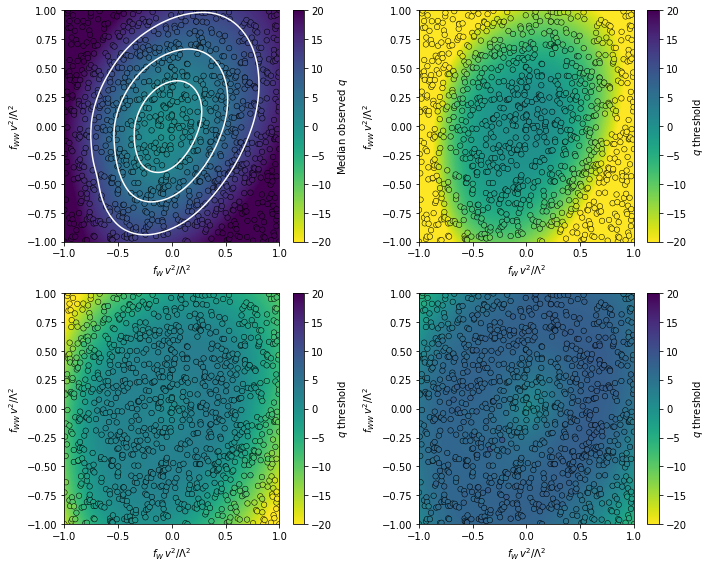

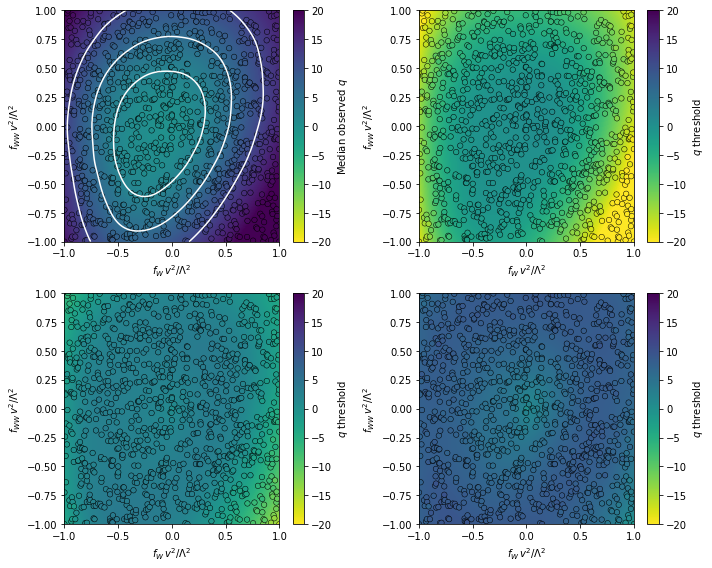

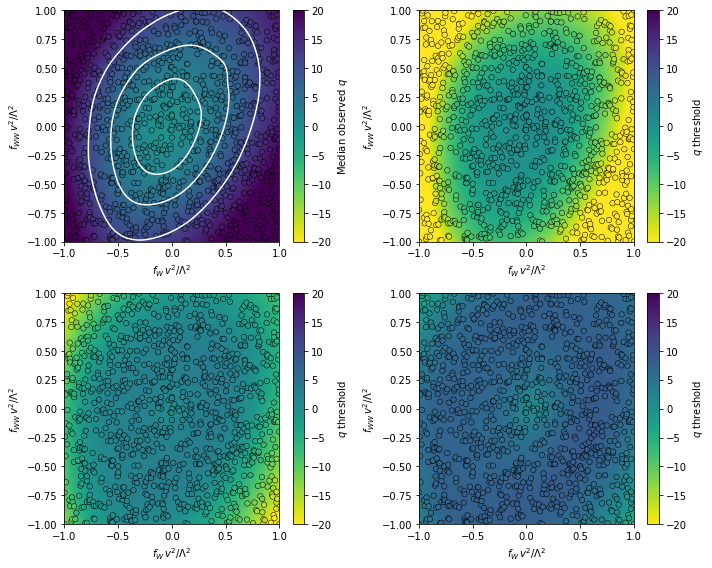

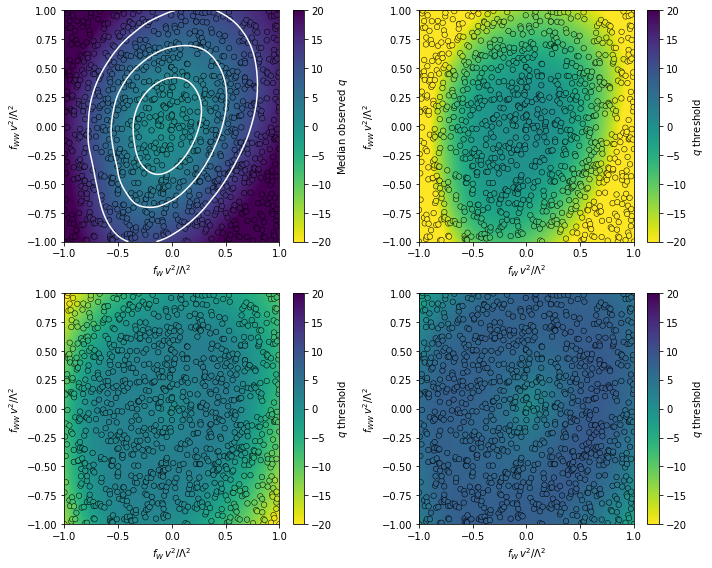

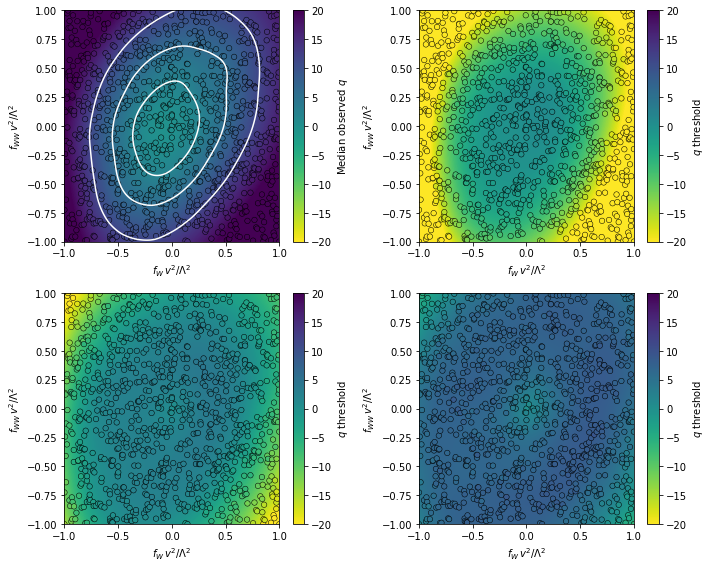

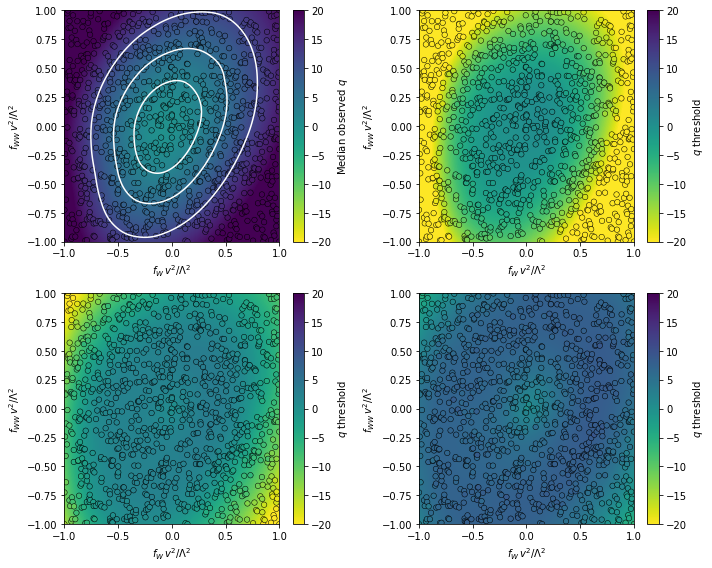

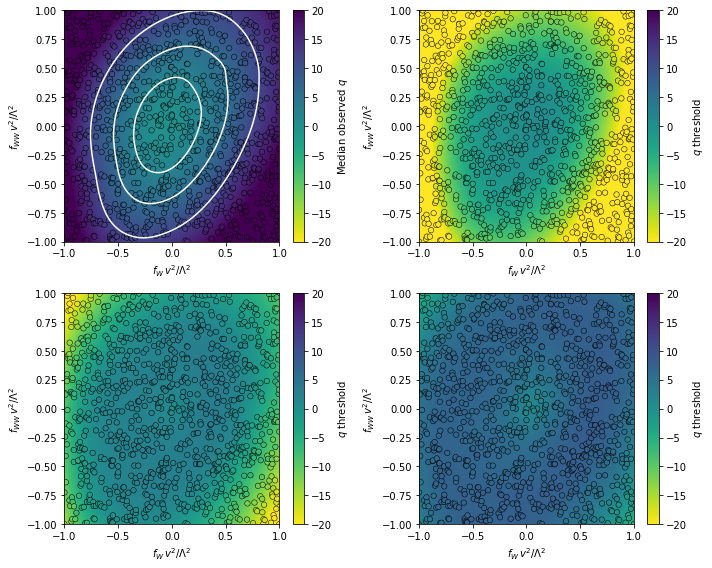

In [9]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

# first, interpolate LLR results
interpolated_expected_llr = []
interpolated_expected_llr_mle = []
interpolated_expected_llr_median = []
interpolated_expected_llr_min = []
interpolated_expected_llr_max = []

for llr, llr_ensemble in zip(expected_llr, expected_llr_ensemble):
    _llr, _mle = interpolate(thetas, llr, xx, yy, method=interpolation_method, subtract_min=False)
    _llr -= llr[settings.theta_observed]
    
    if llr_ensemble is not None:
        _llr_ensemble = [_llr]
        for i, llr_from_ensemble in enumerate(llr_ensemble):
            _llr_ens, _ = interpolate(thetas, llr_from_ensemble, xx, yy,
                                      method=interpolation_method, subtract_min=False)
            _llr_ens -= llr_ensemble[i][settings.theta_observed]
            _llr_ensemble.append(_llr_ens)
        _llr_ensemble = np.asarray(_llr_ensemble)
        
        _llr_median = np.median(_llr_ensemble, axis=0)
        _llr_min = np.min(_llr_ensemble, axis=0)
        _llr_max = np.max(_llr_ensemble, axis=0)
            
    else:
        _llr_ensemble = None
        _llr_median = _llr
        _llr_min = _llr
        _llr_max = _llr
        
    interpolated_expected_llr.append(_llr)
    interpolated_expected_llr_mle.append(_mle)
    interpolated_expected_llr_median.append(_llr_median)
    interpolated_expected_llr_min.append(_llr_min)
    interpolated_expected_llr_max.append(_llr_max)
    
if neyman_plots:
    interpolated_q_medians = []
    interpolated_q_thresholds = []
    interpolated_cl_excluded = []

    for i, (qmed, qthresh, qthresh_err) in enumerate(zip(q_medians, q_thresholds, q_threshold_uncertainties)):
            
        print('Starting strategy {} / {}'.format(i + 1, n_strategies))

        if qmed is None or qthresh is None or qthresh_err is None:
            interpolated_q_medians.append(None)
            interpolated_q_thresholds.append(None)
            interpolated_cl_excluded.append(None)
            continue

        try:
            cut = np.all(np.isfinite(qthresh),axis=1) & (np.isfinite(qmed)) & np.all(np.isfinite(qthresh_err),axis=1)
            
            _qmed, _ = interpolate(thetas[cut], qmed[cut], xx, yy,
                                  method='gp',
                                  length_scale_default=0.1, length_scale_min=0.01, length_scale_max=1.,
                                  matern_exponent=2.5,
                                  noise_level=0.01)
            
            _qthreshs = []
            for j in range(len(settings.confidence_levels)):
                _qthresh, _ = interpolate(thetas[cut], qthresh[cut,j], xx, yy,
                                         z_uncertainties_thetas=2*qthresh_err[cut,j],
                                         method='gp',
                                         length_scale_default=1., length_scale_min=0.5, length_scale_max=2.,
                                         matern_exponent=2.5,
                                         noise_level=0.01)
                _qthreshs.append(copy.deepcopy(_qthresh))
            _qthreshs = np.asarray(_qthreshs)

            _excludeds = np.asarray([_qmed - _qthreshs[j] for j in range(_qthreshs.shape[0])])

            interpolated_q_medians.append(_qmed)
            interpolated_q_thresholds.append(_qthreshs)
            interpolated_cl_excluded.append(_excludeds)
            
            # Debug plot
            zmin, zmax = -20.,20.
            plt.figure(figsize=(10,8))

            plt.subplot(2,2,1)
            zi = np.clip(_qmed,zmin,zmax)
            cs = plt.contourf(xi, yi, zi, 100, cmap='viridis_r', vmin=zmin, vmax=zmax)
            plt.scatter(thetas[:,0], thetas[:,1], c=qmed[:],
                        s=30., lw=0.5, cmap='viridis_r', edgecolors='k', vmin=zmin, vmax=zmax)
            cbar = plt.colorbar()
            cs = plt.contour(xi, yi, zi, [settings.q_threshold],
                             linewidths=1.5, colors='w',
                             linestyles='solid')
            plt.xlim(-1.,1.)
            plt.ylim(-1.,1.)
            plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
            plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
            cbar.set_label('Median observed $q$')
            
            for j in range(len(settings.confidence_levels)):
                plt.subplot(2,2,j+2)
                zi = np.clip(_qthreshs[j], zmin, zmax)
                cs = plt.contourf(xi, yi, zi, 100, cmap='viridis_r', vmin=zmin, vmax=zmax)
                plt.scatter(thetas[:,0], thetas[:,1], c=qthresh[:,j],
                            s=30., lw=0.5, cmap='viridis_r', edgecolors='k', vmin=zmin, vmax=zmax)
                cbar = plt.colorbar()
                plt.xlim(-1.,1.)
                plt.ylim(-1.,1.)
                plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
                plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
                cbar.set_label('$q$ threshold')

            plt.tight_layout()
            plt.savefig("../figures/neyman/cl_interpolation_" + suffices[i] + ".pdf")

        except ValueError as err:
            print(err)
            interpolated_q_medians.append(None)
            interpolated_q_thresholds.append(None)
            interpolated_cl_excluded.append(None)

In [10]:
if neyman_plots:
    interpolated_cl_excluded = []
    for _qmed, _qthreshs in zip(interpolated_q_medians, interpolated_q_thresholds):
        if _qmed is None:
            interpolated_cl_excluded.append(None)
        else:
            interpolated_cl_excluded.append(np.asarray([_qmed - _qthreshs[j] for j in range(_qthreshs.shape[0])]))

# Calculate p values from Asimov data

In [11]:
interpolated_p_values_asymptotics = []
interpolated_p_values_asymptotics_median = []
interpolated_p_values_asymptotics_lower_bound = []
interpolated_p_values_asymptotics_upper_bound = []

for llrs in interpolated_expected_llr:
    pvals = []
    
    for llr in llrs.flatten():
        pvals.append(asymptotic_p_value(llr, use_median_rather_than_asimov=True))
    pvals = np.asarray(pvals)
    
    pvals = pvals.reshape(llrs.shape)
    interpolated_p_values_asymptotics.append(pvals)
    
    
for medians, mins, maxs in zip(interpolated_expected_llr_median, interpolated_expected_llr_min, interpolated_expected_llr_max):
    pvals_median = []
    pvals_lower = []
    pvals_upper = []
                         
    for median, lmin, lmax in zip(medians.flatten(), mins.flatten(), maxs.flatten()):
        pvals_median.append(asymptotic_p_value(median, use_median_rather_than_asimov=use_median_rather_than_asimov))
        pvals_lower.append(asymptotic_p_value(lmin, use_median_rather_than_asimov=use_median_rather_than_asimov))
        pvals_upper.append(asymptotic_p_value(lmax, use_median_rather_than_asimov=use_median_rather_than_asimov))
                         
    pvals_median = np.asarray(pvals_median)
    pvals_lower = np.asarray(pvals_lower)
    pvals_upper = np.asarray(pvals_upper)
                         
    pvals_median = pvals_median.reshape(medians.shape)
    pvals_lower = pvals_lower.reshape(medians.shape)
    pvals_upper = pvals_upper.reshape(medians.shape)
                         
    interpolated_p_values_asymptotics_median.append(pvals_median)
    interpolated_p_values_asymptotics_lower_bound.append(pvals_lower)
    interpolated_p_values_asymptotics_upper_bound.append(pvals_upper)
    

# Benchmark theta: approximate r(x) vs r(x,z)

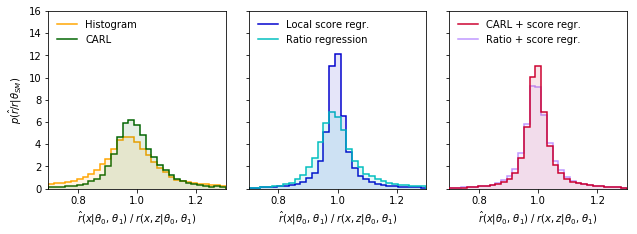

In [26]:
xmin, xmax = 0.7,1.3
bins=31

fig = plt.figure(figsize=(9., calculate_height(3,9.)))

for panel in range(3):
    
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)
    
    for i, s in enumerate(panel_indices[panel]):
        plt.hist(r_benchmark[s] / r_benchmark[truth_index],
                 range=(xmin, xmax), bins=bins, color=colors[s], alpha=0.1, density=True)
    for i, s in enumerate(panel_indices[panel]):
        plt.hist(r_benchmark[s] / r_benchmark[truth_index],
                 range=(xmin, xmax), bins=bins,
                 color=colors[s], histtype='step', lw=1.5, ls='-',density=True,
                zorder=zorders[s])
        plt.plot([],[],lw=1.5,ls='-',c=colors[s],label=labels[s])
        
    plt.legend(loc='upper left', frameon=False)
    
    plt.xlim(xmin,xmax)
    plt.ylim(0.,16.)
    plt.xlabel(r"$\hat{r}(x| \theta_0,\,\theta_1) \;/\; r(x,z| \theta_0,\,\theta_1)$")
    if panel == 0:
        plt.ylabel(r"$p(\hat{r} / r | \theta_{SM})$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/paper/r_smearing.pdf")

# CL contours from asymptotics (expected LLR contours)

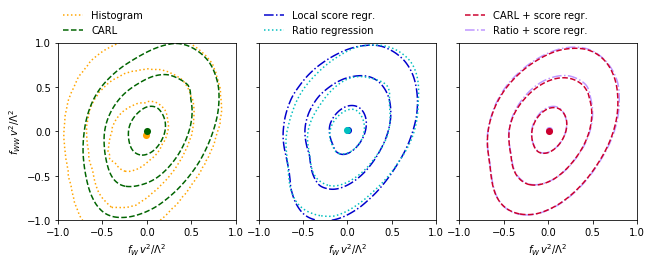

In [27]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

p_value_lines = [0.003,0.05,0.32]

fig = plt.figure(figsize=(9.,calculate_height(3,9.,1.,True)))

for panel in range(3):
    
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)
        
    for s in panel_indices[panel]:
        cs = plt.contour(xi, yi, interpolated_p_values_asymptotics[s], p_value_lines,
                         linewidths=linewidths[s], colors=colors[s], zorder=zorders[s],
                         linestyles=linestyles[s])
        cs.collections[0].set_label(labels[s])

    for s in panel_indices[panel]:
        plt.scatter([xi[interpolated_expected_llr_mle[s][1]]],
                    [yi[interpolated_expected_llr_mle[s][0]]],
                    marker='o', c=colors[s], s=50, lw=0, zorder=10 + zorders[s])

    plt.legend(loc='lower left', bbox_to_anchor=(-0.02,.99), frameon=False)

    plt.xlim(-1, 1.)
    plt.ylim(-1, 1.)
    plt.xticks(np.linspace(-1.,1.,5))
    plt.yticks(np.linspace(-1.,1.,5))
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    if panel==0:
        plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.,1.,True)
plt.savefig("../figures/paper/constraints_asymptotics_smearing.pdf")

# CL contours from Neyman construction

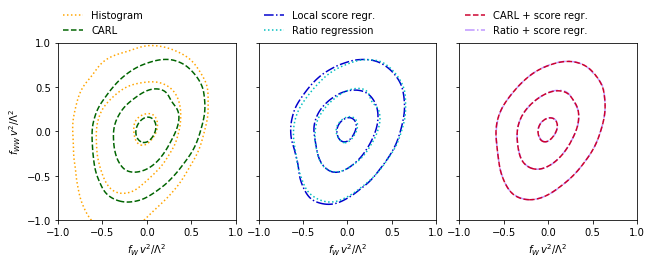

In [28]:
if neyman_plots:
    fig = plt.figure(figsize=(9.,calculate_height(3,9.,1,True)))

    for panel in range(3):

        if panel == 0:
            ax0 = plt.subplot(1, 3, panel+1)
        else:
            ax = plt.subplot(1, 3, panel+1, sharey=ax0)

        for s in panel_indices[panel]:
            if interpolated_cl_excluded[s] is None:
                continue

            for cl in range(len(interpolated_cl_excluded[truth_index])):
                cs = plt.contour(xi, yi, interpolated_cl_excluded[s][cl], [0.],
                                 linewidths=linewidths[s], colors=colors[s], zorder=zorders[s],
                                 linestyles=linestyles[s])
                if cl==0:
                    cs.collections[0].set_label(labels[s])

        plt.legend(loc='lower left', bbox_to_anchor=(-0.02,.99), frameon=False)

        plt.xlim(-1, 1.)
        plt.ylim(-1, 1.)
        plt.xticks(np.linspace(-1.,1.,5))
        plt.yticks(np.linspace(-1.,1.,5))
        
        plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
        if panel==0:
            plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
        else:
            plt.setp(ax.get_yticklabels(), visible=False)

    adjust_margins(3,9.,1,True)
    plt.savefig("../figures/paper/constraints_nc_smearing.pdf")